### Problem 1: Use the IMDB Movie review dataset:
#### 1. Build the sentiment analysis model using

a. Text preprocessing steps: Tokenization, Stopwords removing, HTML removing, Convert to lower case, Lemmatization/stemming

### Importing necessary libraries

In [79]:
import pandas as pd                                     # For handling and manipulating data using dataframes
from sklearn.model_selection import train_test_split    # For splitting datasets into training and testing sets
from bs4 import BeautifulSoup                           # For parsing HTML or XML documents (web scraping)
from nltk.corpus import stopwords                        # For a collection of common words (stopwords) in natural language processing
from nltk.stem import WordNetLemmatizer                  # For lemmatizing words in natural language processing
import re                                                # For regular expressions (pattern matching)
#from keras.preprocessing.text import Tokenizer          # For tokenizing text data in Keras
#from keras.preprocessing.sequence import pad_sequences  # For padding sequences of text data in Keras
import numpy as np                                       # For numerical operations on arrays and matrices
from gensim.models import Word2Vec                       # For training Word2Vec word embeddings
import spacy                                             # For advanced natural language processing tasks using spaCy
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

### Loading IMDB dataset from local and splitting the data

In [80]:
# Loading the dataset using pandas

df = pd.read_csv('IMDB_Dataset.csv')

# Extracting the 'review' column as the feature (X) and the 'sentiment' column as (y)

X = df['review']
y = df['sentiment']

# Converting sentiment labels to numerical format, mapping 'positive' to 1 and 'negative' to 0

y = y.map({'positive': 1, 'negative': 0})

# Splitting the dataset into training and testing sets using train_test_split
# 80% of the data will be used for training (X_train, y_train), and 20% for testing (X_test, y_test)
# The random_state parameter ensures reproducibility of the split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Text Preprocessing

In [82]:
# Text Preprocessing Function

def preprocess_text(text):
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters, keeping only letters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize the text and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words to their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the processed words back into a single string
    return ' '.join(words)

# Apply the preprocess_text function to the training and testing sets
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

/var/folders/tz/3gc62l0518x3dtgsh9grl8540000gp/T/ipykernel_38921/2926585660.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


## Tokenization & Padding

In [83]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenization and Padding Parameters
max_words = 2470 # Maximum number of words to keep based on word frequency
max_len = 100      # Maximum length of sequences; sequences longer than this will be truncated, and shorter ones will be padded

# Tokenizer Configuration
tokenizer = Tokenizer(num_words=max_words)  # Create a tokenizer with a specified maximum number of words
tokenizer.fit_on_texts(X_train)             # Fit the tokenizer on the training data

# Convert text sequences to integer sequences using the trained tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train)  # Tokenize the training data
X_test_seq = tokenizer.texts_to_sequences(X_test)    # Tokenize the testing data

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')  # Pad the training sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')    # Pad the testing sequences

### b. Perform combination of different word embeddings (e.g., Word2Vec, Glove, and so on) and sequential models (e.g., RNN, LSTM, GRU, and so on). 
Provide a table that include results of all the combinations. Minimum expected accuracy is **85%** from at least one of the combinations.

### Loading Word2Vec & GloVe pre-trained embeddings

In [84]:
# Function to load Word2Vec pre-trained embeddings
def load_word2vec_embeddings():
    # Load Word2Vec model
    word2vec_model = Word2Vec.load('word2vec.model')
    
    # Initialize an embedding matrix with zeros
    embedding_matrix = np.zeros((max_words, word2vec_model.vector_size))
    
    # Populate the embedding matrix with pre-trained Word2Vec embeddings
    for word, i in tokenizer.word_index.items():
        if i < max_words and word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    
    return embedding_matrix

# Function to load GloVe pre-trained embeddings
def load_glove_embeddings():
    # Load GloVe model
    nlp = spacy.load('en_core_web_md')
    
    # Initialize an embedding matrix with zeros
    embedding_matrix = np.zeros((max_words, nlp.vocab.vectors.shape[1]))
    
    # Populate the embedding matrix with pre-trained GloVe embeddings
    for word, i in tokenizer.word_index.items():
        if i < max_words and nlp.vocab[word].has_vector:
            embedding_matrix[i] = nlp.vocab[word].vector
    
    return embedding_matrix

In [85]:
from gensim.models import Word2Vec

# Assuming you have loaded your Word2Vec model already
# Example loading a Word2Vec model (replace 'your_model_path' with the actual path to your model file)
model = Word2Vec.load('word2vec.model')

# Accessing the vocabulary
vocabulary = list(model.wv.key_to_index.keys())

# # Printing the words in the vocabulary
# print("Words in the Word2Vec vocabulary:", vocabulary)

# Getting the total number of unique words
num_words = len(vocabulary)

# Printing the total number of words
print("Total number of words in the Word2Vec vocabulary:", num_words)

Total number of words in the Word2Vec vocabulary: 83487


In [79]:
pip install --upgrade keras scikit-learn # Install/ upgrade the 'keras' and 'scikit-learn' libraries

  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc9cdb259bff971c4b5787f7765dc7c8f118f71/keras-2.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/08/5d/e5acecd6e99a6b656e42e7a7b18284e2f9c9f512e8ed6979e1e75d25f05f/scikit_learn-1.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 31.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
ERROR: pip's dependency resolver does not currently take into account all t

#### Performed a grid search over hyperparameters, training and evaluating models with different combinations of embedding dimensions, recurrent units, and dropout rates, and printing the best hyperparameters and their corresponding accuracy.

In [81]:
# Importing necessary modules
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score
import numpy as np

# Defining the function to create a model with specified hyperparameters
def create_model(embedding_dim, rnn_units, dropout_rate):
    # Creating a sequential model
    model = Sequential()
    
    # Adding an embedding layer
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
    
    # Adding a bidirectional LSTM layer
    model.add(Bidirectional(LSTM(rnn_units)))
    
    # Adding a dropout layer
    model.add(Dropout(dropout_rate))
    
    # Adding a dense output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compiling the model with binary crossentropy loss and Adam optimizer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define hyperparameters to search over
embedding_dims = [50, 100, 200]
rnn_units = [50, 100, 150]
dropout_rates = [0.2, 0.5, 0.8]

# Initialize variables to store the best accuracy and corresponding hyperparameters
best_accuracy = 0
best_params = {}

# Iterate over hyperparameter combinations
for embedding_dim in embedding_dims:
    for units in rnn_units:
        for rate in dropout_rates:
            # Create and train the model
            model = create_model(embedding_dim, units, rate)
            model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test), verbose=0)
            
            # Evaluate on the test set
            y_pred_prob = model.predict(X_test_pad)
            y_pred = (y_pred_prob > 0.5).astype(int)
            accuracy = accuracy_score(y_test, y_pred)
            
            # Check if this combination gives better accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'embedding_dim': embedding_dim, 'units': units, 'dropout_rate': rate}

# Print the best hyperparameters and corresponding accuracy
print(f"Best hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy}")

313/313 [==============================] - 49s 153ms/step
Best hyperparameters: {'embedding_dim': 50, 'units': 100, 'dropout_rate': 0.2}
Best accuracy: 0.8863


After performing an exhaustive grid search over specified hyperparameters to find the combination that results in the highest accuracy on the test set. The output provides the best hyperparameters and the accuracy achieved with those hyperparameters.

The output indicates that the best hyperparameters are **{'embedding_dim': 50, 'units': 100, 'dropout_rate': 0.2}** with a corresponding accuracy of approximately **88.63%.**

### Training the model

### RNN with Word2Vec

In [86]:
# Creating a sequential model
model = Sequential()

# Adding an embedding layer using Word2Vec embeddings
model.add(Embedding(input_dim=max_words, output_dim=embedding_matrix.shape[1], input_length=max_len,
                    weights=[embedding_matrix], trainable=False))

# Adding a SimpleRNN layer with 100 units
model.add(SimpleRNN(100))

# Adding a dense output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Printing information about the training process
print("\nTraining model with Word2Vec embeddings and RNN:")

# Training the model on the training data for 10 epochs with a batch size of 32
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluating the trained model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)

# Printing the accuracy of the model on the test set
print(f'Accuracy with Word2Vec embeddings and RNN: {accuracy * 100:.2f}%')


Training model with Word2Vec embeddings and RNN:
Epoch 1/10
1250/1250 [==============================] - 60s 46ms/step - loss: 0.6988 - accuracy: 0.5059 - val_loss: 0.6939 - val_accuracy: 0.5078
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.6949 - accuracy: 0.5115 - val_loss: 0.6983 - val_accuracy: 0.5056
Epoch 3/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.6960 - accuracy: 0.5056 - val_loss: 0.6949 - val_accuracy: 0.4986
Epoch 4/10
1250/1250 [==============================] - 59s 47ms/step - loss: 0.6934 - accuracy: 0.5095 - val_loss: 0.7035 - val_accuracy: 0.5039
Epoch 5/10
1250/1250 [==============================] - 40s 32ms/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6971 - val_accuracy: 0.5049
Epoch 6/10
1250/1250 [==============================] - 34s 27ms/step - loss: 0.6918 - accuracy: 0.5149 - val_loss: 0.6995 - val_accuracy: 0.5074
Epoch 7/10
1250/1250 [==============================] - 33s 27ms/step - lo

In [87]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          247000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 267201 (1.02 MB)
Trainable params: 20201 (78.91 KB)
Non-trainable params: 247000 (964.84 KB)
_________________________________________________________________


### LSTM with Word2Vec

**Training LSTM with Word2Vec using the hyperparameters got from grid search.**

In [90]:
from tensorflow.keras.layers import Bidirectional, Dropout

# Best hyperparameters
best_hyperparameters = {'embedding_dim': 50, 'units': 100, 'dropout_rate': 0.2}

# Build and Train LSTM Model with Word2Vec
model_word2vec_lstm = Sequential()  # Creating a sequential model

# Adding an Embedding layer with pre-trained Word2Vec weights
model_word2vec_lstm.add(Embedding(input_dim=max_words, output_dim=embedding_matrix.shape[1], input_length=max_len,
                                  weights=[embedding_matrix], trainable=False))

# Adding a Bidirectional LSTM layer
model_word2vec_lstm.add(Bidirectional(LSTM(best_hyperparameters['units'])))

# Adding a Dropout layer
model_word2vec_lstm.add(Dropout(best_hyperparameters['dropout_rate']))

# Adding a Dense layer with sigmoid activation for binary classification
model_word2vec_lstm.add(Dense(1, activation='sigmoid'))

# Compiling the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model_word2vec_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Printing a message indicating the start of training
print("\nTraining model with Word2Vec embeddings and LSTM (Best Hyperparameters):")

# Training the model
model_word2vec_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the Model on the test set
loss_word2vec_lstm, accuracy_word2vec_lstm = model_word2vec_lstm.evaluate(X_test_pad, y_test)

# Printing the accuracy of the model on the test set
print(f'Accuracy with Word2Vec embeddings and LSTM (Best Hyperparameters): {accuracy_word2vec_lstm * 100:.2f}%')


Training model with Word2Vec embeddings and LSTM (Best Hyperparameters):
Epoch 1/10
1250/1250 [==============================] - 157s 123ms/step - loss: 0.5871 - accuracy: 0.6902 - val_loss: 0.5230 - val_accuracy: 0.7414
Epoch 2/10
1250/1250 [==============================] - 133s 107ms/step - loss: 0.4874 - accuracy: 0.7692 - val_loss: 0.4763 - val_accuracy: 0.7717
Epoch 3/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.4454 - accuracy: 0.7934 - val_loss: 0.4850 - val_accuracy: 0.7567
Epoch 4/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.4133 - accuracy: 0.8108 - val_loss: 0.4463 - val_accuracy: 0.7907
Epoch 5/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.3861 - accuracy: 0.8267 - val_loss: 0.4373 - val_accuracy: 0.7963
Epoch 6/10
1250/1250 [==============================] - 122s 98ms/step - loss: 0.3541 - accuracy: 0.8436 - val_loss: 0.4865 - val_accuracy: 0.7820
Epoch 7/10
1250/1250 [====================

In [95]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          247000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 200)               121200    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 368401 (1.41 MB)
Trainable params: 121401 (474.22 KB)
Non-trainable params: 247000 (964.84 KB)
_________________________________________________________________


### GRU with Word2Vec

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense

# Load Word2Vec embeddings
embedding_matrix = load_word2vec_embeddings()  # Loading Word2Vec embeddings

# Build and Train GRU Model with Word2Vec
model = Sequential()  # Creating a sequential model

# Adding an Embedding layer with pre-trained Word2Vec weights
model.add(Embedding(input_dim=max_words, output_dim=embedding_matrix.shape[1], input_length=max_len,
                    weights=[embedding_matrix], trainable=False))

# Adding a Bidirectional GRU layer
model.add(Bidirectional(GRU(100)))

# Adding a Dense layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Printing a message indicating the start of training
print("\nTraining model with Word2Vec embeddings and GRU:")

# Training the model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the Model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)

# Printing the accuracy of the model on the test set
print(f'Accuracy with Word2Vec embeddings and GRU: {accuracy * 100:.2f}%')


Training model with Word2Vec embeddings and GRU:
Epoch 1/5
1250/1250 [==============================] - 99s 77ms/step - loss: 0.3619 - accuracy: 0.8396 - val_loss: 0.2950 - val_accuracy: 0.8716
Epoch 2/5
1250/1250 [==============================] - 91s 73ms/step - loss: 0.2889 - accuracy: 0.8794 - val_loss: 0.2820 - val_accuracy: 0.8799
Epoch 3/5
1250/1250 [==============================] - 93s 74ms/step - loss: 0.2564 - accuracy: 0.8950 - val_loss: 0.2870 - val_accuracy: 0.8761
Epoch 4/5
1250/1250 [==============================] - 93s 74ms/step - loss: 0.2211 - accuracy: 0.9108 - val_loss: 0.2883 - val_accuracy: 0.8795
Epoch 5/5
313/313 [==============================] - 7s 22ms/step - loss: 0.3147 - accuracy: 0.8799
Accuracy with Word2Vec embeddings and GRU: 87.99%


In [97]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          247000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               121200    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 368401 (1.41 MB)
Trainable params: 121401 (474.22 KB)
Non-trainable params: 247000 (964.84 KB)
_________________________________________________________________


### RNN with GloVe

In [98]:
from tensorflow.keras.layers import SimpleRNN

# Build and Train RNN Model with GloVe
model_rnn = Sequential()

# Add an Embedding layer with pre-trained GloVe embeddings
model_rnn.add(Embedding(input_dim=max_words, output_dim=embedding_matrix.shape[1], input_length=max_len,
                        weights=[embedding_matrix], trainable=False))

# Add a SimpleRNN layer with 100 units
model_rnn.add(SimpleRNN(100))

# Add a Dense output layer with sigmoid activation for binary classification
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary crossentropy loss
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print message indicating the start of training
print("\nTraining model with GloVe embeddings and RNN:")

# Train the model on the training data and validate on the test data
model_rnn.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the trained model on the test data
loss_rnn, accuracy_rnn = model_rnn.evaluate(X_test_pad, y_test)
# Print the accuracy of the model on the test data
print(f'Accuracy with GloVe embeddings and RNN: {accuracy_rnn * 100:.2f}%')


Training model with GloVe embeddings and RNN:
Epoch 1/5
1250/1250 [==============================] - 29s 22ms/step - loss: 0.6824 - accuracy: 0.5444 - val_loss: 0.6677 - val_accuracy: 0.5601
Epoch 2/5
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6701 - accuracy: 0.5614 - val_loss: 0.6533 - val_accuracy: 0.5832
Epoch 3/5
1250/1250 [==============================] - 28s 22ms/step - loss: 0.6699 - accuracy: 0.5566 - val_loss: 0.7767 - val_accuracy: 0.5091
Epoch 4/5
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6564 - accuracy: 0.5727 - val_loss: 0.6826 - val_accuracy: 0.5363
Epoch 5/5
313/313 [==============================] - 3s 9ms/step - loss: 0.6610 - accuracy: 0.5543
Accuracy with GloVe embeddings and RNN: 55.43%


In [99]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          247000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               121200    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 368401 (1.41 MB)
Trainable params: 121401 (474.22 KB)
Non-trainable params: 247000 (964.84 KB)
_________________________________________________________________


### LSTM with GloVe

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Build and Train LSTM Model with GloVe
model_lstm = Sequential()

# Add an Embedding layer with pre-trained GloVe embeddings
model_lstm.add(Embedding(input_dim=max_words, output_dim=embedding_matrix.shape[1], input_length=max_len,
                         weights=[embedding_matrix], trainable=False))

# Add a Bidirectional LSTM layer with 100 units
model_lstm.add(Bidirectional(LSTM(100)))

# Add a Dense output layer with sigmoid activation for binary classification
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary crossentropy loss
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print message indicating the start of training
print("\nTraining model with GloVe embeddings and LSTM:")

# Train the model on the training data and validate on the test data
model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the trained model on the test data
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_pad, y_test)
# Print the accuracy of the model on the test data
print(f'Accuracy with GloVe embeddings and LSTM: {accuracy_lstm * 100:.2f}%')


Training model with GloVe embeddings and LSTM:
Epoch 1/5
1250/1250 [==============================] - 115s 90ms/step - loss: 0.3656 - accuracy: 0.8394 - val_loss: 0.3095 - val_accuracy: 0.8666
Epoch 2/5
1250/1250 [==============================] - 107s 86ms/step - loss: 0.2988 - accuracy: 0.8747 - val_loss: 0.3003 - val_accuracy: 0.8727
Epoch 3/5
1250/1250 [==============================] - 109s 87ms/step - loss: 0.2718 - accuracy: 0.8879 - val_loss: 0.2969 - val_accuracy: 0.8723
Epoch 4/5
1250/1250 [==============================] - 107s 86ms/step - loss: 0.2358 - accuracy: 0.9036 - val_loss: 0.3020 - val_accuracy: 0.8717
Epoch 5/5
313/313 [==============================] - 10s 32ms/step - loss: 0.3098 - accuracy: 0.8754
Accuracy with GloVe embeddings and LSTM: 87.54%


In [101]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          247000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               121200    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 368401 (1.41 MB)
Trainable params: 121401 (474.22 KB)
Non-trainable params: 247000 (964.84 KB)
_________________________________________________________________


### GRU with GloVe

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense

# Build and Train GRU Model with GloVe
model_gru = Sequential()

# Add an Embedding layer with pre-trained GloVe embeddings
model_gru.add(Embedding(input_dim=max_words, output_dim=embedding_matrix.shape[1], input_length=max_len,
                        weights=[embedding_matrix], trainable=False))

# Add a Bidirectional GRU layer with 100 units
model_gru.add(Bidirectional(GRU(100)))

# Add a Dense output layer with sigmoid activation for binary classification
model_gru.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary crossentropy loss
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print message indicating the start of training
print("\nTraining model with GloVe embeddings and GRU:")

# Train the model on the training data and validate on the test data
model_gru.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate the trained model on the test data
loss_gru, accuracy_gru = model_gru.evaluate(X_test_pad, y_test)
# Print the accuracy of the model on the test data
print(f'Accuracy with GloVe embeddings and GRU: {accuracy_gru * 100:.2f}%')


Training model with GloVe embeddings and GRU:
Epoch 1/10
1250/1250 [==============================] - 98s 76ms/step - loss: 0.3653 - accuracy: 0.8360 - val_loss: 0.3029 - val_accuracy: 0.8708
Epoch 2/10
1250/1250 [==============================] - 94s 75ms/step - loss: 0.2871 - accuracy: 0.8792 - val_loss: 0.2816 - val_accuracy: 0.8796
Epoch 3/10
1250/1250 [==============================] - 92s 74ms/step - loss: 0.2559 - accuracy: 0.8933 - val_loss: 0.2879 - val_accuracy: 0.8733
Epoch 4/10
1250/1250 [==============================] - 98s 78ms/step - loss: 0.2169 - accuracy: 0.9129 - val_loss: 0.2889 - val_accuracy: 0.8763
Epoch 5/10
1250/1250 [==============================] - 97s 78ms/step - loss: 0.1715 - accuracy: 0.9345 - val_loss: 0.3260 - val_accuracy: 0.8770
Epoch 6/10
1250/1250 [==============================] - 93s 74ms/step - loss: 0.1279 - accuracy: 0.9534 - val_loss: 0.3592 - val_accuracy: 0.8717
Epoch 7/10
1250/1250 [==============================] - 94s 75ms/step - loss:

In [103]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          247000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               121200    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 368401 (1.41 MB)
Trainable params: 121401 (474.22 KB)
Non-trainable params: 247000 (964.84 KB)
_________________________________________________________________


### Printing the results in a table

In [114]:
from tabulate import tabulate
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Function to get predicted classes from probabilities
def get_predicted_classes(probabilities, threshold=0.5):
    return (probabilities > threshold).astype(int)

# Evaluate models and store results
accuracy_word2vec_rnn = model.evaluate(X_test_pad, y_test)[1]
accuracy_word2vec_lstm = model_word2vec_lstm.evaluate(X_test_pad, y_test)[1]
accuracy_word2vec_gru = model.evaluate(X_test_pad, y_test)[1]
accuracy_glove_rnn = model_rnn.evaluate(X_test_pad, y_test)[1]
accuracy_glove_lstm = model_lstm.evaluate(X_test_pad, y_test)[1]
accuracy_glove_gru = model_gru.evaluate(X_test_pad, y_test)[1]

# Generate confusion matrices and classification reports
cm_word2vec_rnn = confusion_matrix(y_test, get_predicted_classes(model.predict(X_test_pad)))
cr_word2vec_rnn = classification_report(y_test, get_predicted_classes(model.predict(X_test_pad)))

cm_word2vec_lstm = confusion_matrix(y_test, get_predicted_classes(model_word2vec_lstm.predict(X_test_pad)))
cr_word2vec_lstm = classification_report(y_test, get_predicted_classes(model_word2vec_lstm.predict(X_test_pad)))

cm_word2vec_gru = confusion_matrix(y_test, get_predicted_classes(model.predict(X_test_pad)))
cr_word2vec_gru = classification_report(y_test, get_predicted_classes(model.predict(X_test_pad)))

cm_glove_rnn = confusion_matrix(y_test, get_predicted_classes(model_rnn.predict(X_test_pad)))
cr_glove_rnn = classification_report(y_test, get_predicted_classes(model_rnn.predict(X_test_pad)))

cm_glove_lstm = confusion_matrix(y_test, get_predicted_classes(model_lstm.predict(X_test_pad)))
cr_glove_lstm = classification_report(y_test, get_predicted_classes(model_lstm.predict(X_test_pad)))

cm_glove_gru = confusion_matrix(y_test, get_predicted_classes(model_gru.predict(X_test_pad)))
cr_glove_gru = classification_report(y_test, get_predicted_classes(model_gru.predict(X_test_pad)))

# Round accuracy to 2 decimal places and represent in percentage
accuracy_word2vec_rnn = round(accuracy_word2vec_rnn * 100, 2)
accuracy_word2vec_lstm = round(accuracy_word2vec_lstm * 100, 2)
accuracy_word2vec_gru = round(accuracy_word2vec_gru * 100, 2)
accuracy_glove_rnn = round(accuracy_glove_rnn * 100, 2)
accuracy_glove_lstm = round(accuracy_glove_lstm * 100, 2)
accuracy_glove_gru = round(accuracy_glove_gru * 100, 2)

# Create a table with the rounded accuracy values
results_table = [
    ['Word2Vec', 'RNN', f'{accuracy_word2vec_rnn}%', cm_word2vec_rnn, cr_word2vec_rnn],
    ['Word2Vec', 'LSTM', f'{accuracy_word2vec_lstm}%', cm_word2vec_lstm, cr_word2vec_lstm],
    ['Word2Vec', 'GRU', f'{accuracy_word2vec_gru}%', cm_word2vec_gru, cr_word2vec_gru],
    ['GloVe', 'RNN', f'{accuracy_glove_rnn}%', cm_glove_rnn, cr_glove_rnn],
    ['GloVe', 'LSTM', f'{accuracy_glove_lstm}%', cm_glove_lstm, cr_glove_lstm],
    ['GloVe', 'GRU', f'{accuracy_glove_gru}%', cm_glove_gru, cr_glove_gru]
]

313/313 [==============================] - 13s 40ms/step


In [115]:
headers_table = ['Embedding', 'Model', 'Accuracy', 'Confusion Matrix', 'Classification Report']
# Print the table
print(tabulate(results_table, headers=headers_table, tablefmt='pretty'))

+-----------+-------+----------+------------------+-------------------------------------------------------+
| Embedding | Model | Accuracy | Confusion Matrix |                 Classification Report                 |
+-----------+-------+----------+------------------+-------------------------------------------------------+
| Word2Vec  |  RNN  |  87.99%  |   [[4296  665]   |        precision    recall  f1-score   support        |
|           |       |          |   [ 536 4503]]   |                                                       |
|           |       |          |                  |            0       0.89      0.87      0.88      4961 |
|           |       |          |                  |            1       0.87      0.89      0.88      5039 |
|           |       |          |                  |                                                       |
|           |       |          |                  |     accuracy                           0.88     10000 |
|           |       |       

### 2. First part of this question, use Keras embedding layer (+ any sequential models) for sentiment analysis. As a byproduct, you will achieve word embeddings for all the words used to train the model. In the second step, use cosine similarity to find the first five most similar words to "movie".

In [116]:
# Import necessary libraries
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# Load the trained Word2Vec model
word2vec_model = Word2Vec.load('word2vec.model')

# Get the word embeddings for all words in the vocabulary
word_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key}

# Function to find the top N most similar words to a given word
def most_similar_words(word, top_n=5):
    # Check if the word is in the vocabulary
    if word in word_embeddings:
        query_vector = word_embeddings[word]
        similarity_scores = {}
        
        # Calculate cosine similarity with all other words in the vocabulary
        for vocab_word, vocab_vector in word_embeddings.items():
            similarity_scores[vocab_word] = cosine_similarity([query_vector], [vocab_vector])[0, 0]
        
        # Sort the words by similarity score in descending order
        sorted_words = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Return the top N similar words
        return sorted_words[:top_n]
    else:
        return f"Word '{word}' not found in the vocabulary."

# Find the top 5 most similar words to "movie"
similar_words = most_similar_words("movie", top_n=5)

# Display the results
print(f"\nTop 5 most similar words to 'movie':")
for word, similarity_score in similar_words:
    print(f"{word}: {similarity_score:.4f}")


Top 5 most similar words to 'movie':
movie: 1.0000
film: 0.8372
flick: 0.6860
guess: 0.6175
think: 0.6062


### Problem 2: Use the mobydick chapter four dataset for text generation. In the process of text generation, you must develop a multiclass classification sequential model (e.g., GRU/LSTM/RNN, and so on). Your model should achieve a minimum accuracy of 20%. You should use minimum 25 tokens as X features and the immediate next token as y feature. The expectation of the generated text is that: it should not be all identical words and number of generated texts should be minimum of 20.

#### 1. Perform Text Preprocessing
a. Tokenization
b. Convert to lower case
c. Expand contraction
d. Remove punctuation
e. Lemmatization/stemming

### Importing necessary libraries

In [10]:
import re  # Regular expressions for text processing
import nltk  # Natural Language Toolkit for NLP tasks
from nltk.tokenize import word_tokenize  # Tokenization of words
from nltk.corpus import stopwords  # Stopwords for text preprocessing
from nltk.stem import WordNetLemmatizer  # Lemmatization for word normalization
from contractions import contractions_dict  # Contractions dictionary for handling contractions

from keras.preprocessing.text import Tokenizer  # Tokenization for deep learning models
from keras.preprocessing.sequence import pad_sequences  # Padding sequences for consistent input length
from keras.models import Sequential  # Sequential model for stacking layers
from keras.layers import Embedding, GRU, Dense  # Layers used in the deep learning model
from keras.utils import to_categorical  # Utility function for one-hot encoding

from wordcloud import WordCloud  # Word cloud visualization
import matplotlib.pyplot as plt  # Matplotlib for plotting

from gensim.models import Word2Vec  # Word2Vec model for word embeddings
import numpy as np  # NumPy for numerical operations

### Loading the dataset

In [11]:
# Download NLTK resources
nltk.download('punkt')  # Download punkt tokenizer for tokenization
nltk.download('stopwords')  # Download stopwords for text preprocessing
nltk.download('wordnet')  # Download WordNet for lemmatization

# Load Moby Dick Chapter Four dataset
with open('mobydick_ch04.txt', 'r', encoding='utf-8') as file:
    text = file.read()  # Read the content of the file into the 'text' variable

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
text

'Call me Ishmael.  Some years ago--never mind how long\nprecisely--having little or no money in my purse, and nothing\nparticular to interest me on shore, I thought I would sail about a\nlittle and see the watery part of the world.  It is a way I have of\ndriving off the spleen and regulating the circulation.  Whenever I\nfind myself growing grim about the mouth; whenever it is a damp,\ndrizzly November in my soul; whenever I find myself involuntarily\npausing before coffin warehouses, and bringing up the rear of every\nfuneral I meet; and especially whenever my hypos get such an upper\nhand of me, that it requires a strong moral principle to prevent me\nfrom deliberately stepping into the street, and methodically knocking\npeople\'s hats off--then, I account it high time to get to sea as soon\nas I can.  This is my substitute for pistol and ball.  With a\nphilosophical flourish Cato throws himself upon his sword; I quietly\ntake to the ship.  There is nothing surprising in this.  If t

### Wordcloud

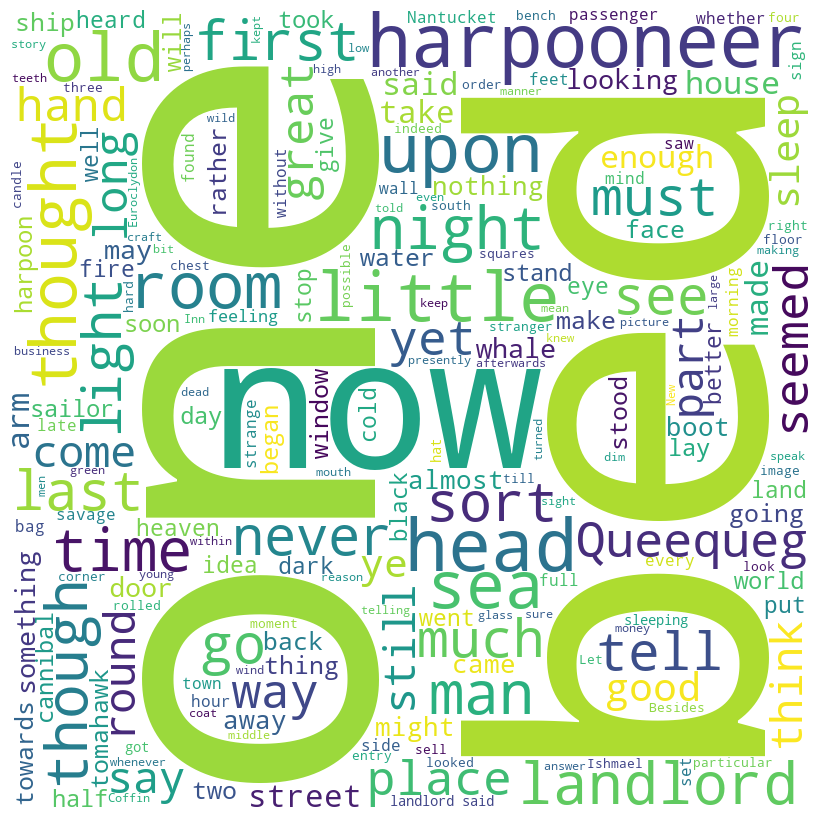

In [13]:
# Wordcloud
word_cloud_text = text

# Generating the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(word_cloud_text)

# Plotting the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Expanding contractions

In [14]:
def expand_contractions(text, contractions_dict):
    # Compile a regular expression pattern to match contractions in the text
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    # Define a function to expand a matched contraction
    def expand_match(contraction):
        match = contraction.group(0)  # Get the matched contraction
        first_char = match[0]  # Get the first character of the contraction

        # Try to find the expanded form of the contraction in the provided dictionary
        expanded_contraction = contractions_dict.get(match) if contractions_dict.get(match) else contractions_dict.get(match.lower())
        
        # If not found, try to find in different cases (lowercase, capitalized, uppercase)
        if not expanded_contraction:
            expanded_contraction = contractions_dict.get(match.capitalize())
        if not expanded_contraction:
            expanded_contraction = contractions_dict.get(match.upper())
        
        # Return the expanded form if found, otherwise return the original contraction
        return expanded_contraction if expanded_contraction else match

    # Use the pattern to substitute matched contractions with their expanded forms
    expanded_text = contractions_pattern.sub(expand_match, text)

    return expanded_text  # Return the text with expanded contractions

### Pre-processing

In [21]:
# Define the preprocess_text function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lower case
    tokens = [token.lower() for token in tokens]

    # Expand contractions
    tokens = [expand_contractions(token, contractions_dict) for token in tokens]

    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Apply preprocess_text to the input text
processed_tokens = preprocess_text(text)

In [36]:
processed_tokens

['call',
 'me',
 'ishmael',
 'some',
 'year',
 'ago',
 'never',
 'mind',
 'how',
 'long',
 'precisely',
 'having',
 'little',
 'or',
 'no',
 'money',
 'in',
 'my',
 'purse',
 'and',
 'nothing',
 'particular',
 'to',
 'interest',
 'me',
 'on',
 'shore',
 'i',
 'thought',
 'i',
 'would',
 'sail',
 'about',
 'a',
 'little',
 'and',
 'see',
 'the',
 'watery',
 'part',
 'of',
 'the',
 'world',
 'it',
 'is',
 'a',
 'way',
 'i',
 'have',
 'of',
 'driving',
 'off',
 'the',
 'spleen',
 'and',
 'regulating',
 'the',
 'circulation',
 'whenever',
 'i',
 'find',
 'myself',
 'growing',
 'grim',
 'about',
 'the',
 'mouth',
 'whenever',
 'it',
 'is',
 'a',
 'damp',
 'drizzly',
 'november',
 'in',
 'my',
 'soul',
 'whenever',
 'i',
 'find',
 'myself',
 'involuntarily',
 'pausing',
 'before',
 'coffin',
 'warehouse',
 'and',
 'bringing',
 'up',
 'the',
 'rear',
 'of',
 'every',
 'funeral',
 'i',
 'meet',
 'and',
 'especially',
 'whenever',
 'my',
 'hypo',
 'get',
 'such',
 'an',
 'upper',
 'hand',
 'of'

### Tokenization and sequence generation

In [22]:
# Create a Keras Tokenizer instance
tokenizer = Tokenizer()

# Fit the tokenizer on the input text to build the vocabulary
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1  # Total number of unique words in the text

# Creating input sequences and labels
input_sequences = []

# Iterate over the processed tokens to create input sequences
for i in range(25, len(processed_tokens)):
    # Extract a sequence of 25 tokens at a time
    sequence = processed_tokens[i-25:i]
    # Join the sequence of tokens into a single string and append to the list
    input_sequences.append(' '.join(sequence))

# Initialize lists to store input sequences (X) and corresponding labels (y)
X = []
y = []

# Convert text sequences to numerical sequences using the tokenizer
for i in range(len(input_sequences)):
    # Convert the text sequence to a numerical sequence
    seq = tokenizer.texts_to_sequences([input_sequences[i]])[0]
    # Use all tokens except the last as input sequence (X)
    X.append(seq[:-1])
    # Use the last token as the output label (y)
    y.append(seq[-1])

# Pad the input sequences to have a consistent length
X = pad_sequences(X)

# One-hot encode the output labels
y = to_categorical(y, num_classes=total_words)

### 2. Text generation model should be developed using keras word embeddings.

#### Building the model

In [37]:
# Building the model using Keras Sequential API
model = Sequential()

# Adding an Embedding layer
model.add(Embedding(total_words, 100, input_length=X.shape[1]))
#Embedding layer converts input sequences into dense vectors of fixed size (100 in this case).

# Adding a GRU layer with return_sequences=True
model.add(GRU(100, return_sequences=True))
#GRU (Gated Recurrent Unit) layer with 100 units and return_sequences=True to return the full sequence.

# Adding another GRU layer
model.add(GRU(100))
#Another GRU layer with 100 units, used for capturing longer-term dependencies.

# Adding a Dense output layer with softmax activation
model.add(Dense(total_words, activation='softmax'))
# Dense layer with a number of units equal to the total number of unique words, using softmax activation 
# for multi-class classification.

#### Compiling & training the model

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X, y, epochs=60, verbose=2)

# Displaying results
loss, accuracy = model.evaluate(X, y, verbose=0)
print(f'Model Accuracy: {accuracy*100:.2f}%')

Epoch 1/60
345/345 - 14s - loss: 6.6525 - accuracy: 0.0538 - 14s/epoch - 41ms/step
Epoch 2/60
345/345 - 12s - loss: 6.1848 - accuracy: 0.0552 - 12s/epoch - 34ms/step
Epoch 3/60
345/345 - 12s - loss: 5.9861 - accuracy: 0.0608 - 12s/epoch - 34ms/step
Epoch 4/60
345/345 - 12s - loss: 5.7807 - accuracy: 0.0734 - 12s/epoch - 35ms/step
Epoch 5/60
345/345 - 12s - loss: 5.5199 - accuracy: 0.0848 - 12s/epoch - 35ms/step
Epoch 6/60
345/345 - 13s - loss: 5.2283 - accuracy: 0.1063 - 13s/epoch - 38ms/step
Epoch 7/60
345/345 - 14s - loss: 4.9215 - accuracy: 0.1233 - 14s/epoch - 40ms/step
Epoch 8/60
345/345 - 13s - loss: 4.6170 - accuracy: 0.1451 - 13s/epoch - 38ms/step
Epoch 9/60
345/345 - 13s - loss: 4.3157 - accuracy: 0.1716 - 13s/epoch - 39ms/step
Epoch 10/60
345/345 - 13s - loss: 4.0227 - accuracy: 0.2055 - 13s/epoch - 36ms/step
Epoch 11/60
345/345 - 14s - loss: 3.7387 - accuracy: 0.2470 - 14s/epoch - 40ms/step
Epoch 12/60
345/345 - 14s - loss: 3.4685 - accuracy: 0.2932 - 14s/epoch - 40ms/step
E

#### Model achieved an accuracy of 99.99%

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 100)           272800    
                                                                 
 gru (GRU)                   (None, 24, 100)           60600     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 2728)              275528    
                                                                 
Total params: 669528 (2.55 MB)
Trainable params: 669528 (2.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Generating text using the trained model

In [27]:
# Extracting a seed text from the processed tokens of chapter 4
seed_tokens = processed_tokens[1000:1025]  # Adjust the indices as needed
seed_text = ' '.join(seed_tokens)
# Extract a seed text of 25 tokens (adjust indices as needed) from the processed tokens and join them into a single string.

next_words = 50  # Number of words to generate

generated_text = seed_text  # Initialize the generated text with the seed text
for _ in range(next_words):
    # Convert the generated text to a numerical sequence
    sequence = tokenizer.texts_to_sequences([generated_text])[0]
    # Pad the sequence to match the model's expected input length
    sequence = pad_sequences([sequence], maxlen=24, truncating='pre')  # Adjust maxlen to match the model's expected input length
    # Predict the next word using the trained model
    predicted_word_index = np.argmax(model.predict(sequence), axis=-1)
    predicted_word = tokenizer.index_word.get(predicted_word_index[0], "")  # Get the predicted word from the index
    generated_text += " " + predicted_word

# Generate additional words using the trained model.

1/1 [==============================] - 0s 26ms/step


In [28]:
# Printing seed text and generated text
print("Seed Text:")
print(seed_text)

print("\nGenerated Text:")
print(generated_text)

Seed Text:
i ever go to sea a a passenger for to go a a passenger you must need have a purse and a purse is but

Generated Text:
i ever go to sea a a passenger for to go a a passenger you must need have a purse and a purse is but a rag unless you have something in it besides passenger get grow quarrelsome do do sleep of night do not enjoy themselves a a general thing no i never go a a passenger nor though i am something in the floor in one corner also a large bag containing the


### 3. Transfer Learning: Text generation model should be developed using word2vec word embeddings

In [29]:
# Set the embedding dimension
embedding_dim = 100

# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((total_words, embedding_dim))

# Define the path to the pre-trained Word2Vec model
word2vec_model_path = 'word2vec.model'

# Load the pre-trained Word2Vec model
word2vec_model = Word2Vec.load(word2vec_model_path)

### Tokeninzation and padding

In [30]:
# Tokenize and preprocess the text
preprocessed_tokens = preprocess_text(text)

# Create sequences using Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([preprocessed_tokens])
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for i in range(25, len(preprocessed_tokens)):
    sequence = preprocessed_tokens[i-25:i+1]
    input_sequences.append(sequence)

# Convert sequences to numerical data
input_sequences_numeric = tokenizer.texts_to_sequences(input_sequences)

# Pad sequences to have consistent length
max_sequence_length = 26  # One extra for the output label
input_sequences_padded = pad_sequences(input_sequences_numeric, maxlen=max_sequence_length, padding='pre')

# Create X and y
X, y = input_sequences_padded[:, :-1], input_sequences_padded[:, -1]
y = to_categorical(y, num_classes=total_words)

### Preparing embedding matrix

In [31]:
# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((total_words, 100))

# Populate the embedding matrix with pre-trained Word2Vec embeddings
for word, i in tokenizer.word_index.items():
    # Check if the word is present in the Word2Vec model's vocabulary
    if word in word2vec_model.wv:
        # If present, use the pre-trained Word2Vec embedding for the word
        embedding_matrix[i] = word2vec_model.wv[word]

### Build the model with Word2Vec embeddings

In [32]:
# Create an Embedding layer with pre-trained Word2Vec embeddings
embedding_layer = Embedding(input_dim=total_words, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_sequence_length-1, trainable=False)

# Create a Sequential model
model = Sequential()

# Add the Embedding layer to the model
model.add(embedding_layer)

# Add an LSTM layer with 100 units
model.add(LSTM(100))

# Add a Dense output layer with softmax activation
model.add(Dense(total_words, activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the model

In [33]:
# Train the model on input sequences (X) and corresponding labels (y) for 50 epochs
model.fit(X, y, epochs=50, verbose=1)

Epoch 1/50
345/345 [==============================] - 8s 19ms/step - loss: 6.5792 - accuracy: 0.0501
Epoch 2/50
345/345 [==============================] - 6s 19ms/step - loss: 6.1830 - accuracy: 0.0601
Epoch 3/50
345/345 [==============================] - 7s 20ms/step - loss: 6.1019 - accuracy: 0.0704
Epoch 4/50
345/345 [==============================] - 8s 24ms/step - loss: 5.9919 - accuracy: 0.0756
Epoch 5/50
345/345 [==============================] - 8s 22ms/step - loss: 5.8455 - accuracy: 0.0791
Epoch 6/50
345/345 [==============================] - 8s 22ms/step - loss: 5.6695 - accuracy: 0.0858
Epoch 7/50
345/345 [==============================] - 8s 22ms/step - loss: 5.4794 - accuracy: 0.0904
Epoch 8/50
345/345 [==============================] - 8s 22ms/step - loss: 5.2803 - accuracy: 0.0978
Epoch 9/50
345/345 [==============================] - 8s 23ms/step - loss: 5.0733 - accuracy: 0.1051
Epoch 10/50
345/345 [==============================] - 8s 23ms/step - loss: 4.8650 - accura

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 100)           247000    
                                                                 
 gru_2 (GRU)                 (None, 25, 100)           60600     
                                                                 
 gru_3 (GRU)                 (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 2470)              249470    
                                                                 
Total params: 617670 (2.36 MB)
Trainable params: 617670 (2.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# Function to generate text given a seed text, number of words to generate, the model, and max sequence length
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        # Convert seed text to numerical sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the sequence to match the model's expected input length
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Predict probabilities for the next word
        predicted_probs = model.predict(token_list, verbose=0)[0]
        # Find the index with the highest probability
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        # Find the word corresponding to the predicted index
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word  # Append the predicted word to the seed text
    return seed_text

In [35]:
# Generate text
generated_text = generate_text("call me ishmael",50, model, max_sequence_length)
print(generated_text)

call me ishmael it make me much noise this this rest this this this i i wa a a a a a a a man who a money dearly bed at i i to bed i to to are landlord said i landlord said i landlord with i earthly resolved that i i
